DS Tourism and Hospitality

Suhana Tunio

Student ID: 223010064

Smart Luggage Management for Tourist Mobility in Melbourne

ALL ABOUT MY USE CASE:


When I began exploring this use case, I wanted to focus on a real problem that many tourists face but often goes unnoticed the challenge of managing luggage while trying to enjoy a city. I realized that in Melbourne, a city filled with vibrant attractions, cultural landmarks, and busy transport hubs, tourists often have to drag their bags around after checking out of their accommodation. This not only limits their ability to move freely but also reduces the quality of their experience, as carrying luggage can discourage them from exploring more places.

My idea was to approach this problem from a data-driven perspective, by looking at how luggage flows between key points such as accommodations, storage facilities, attractions, and transport hubs. By collecting data on footfall, travel distances, accessibility, and locker availability, I could start building a clearer picture of how tourists navigate the city and where they encounter friction. I found it fascinating to think about how something as simple as lockers and luggage routes could make such a big difference to both tourists and the city itself.

Through clustering, machine learning, and graph mapping, I aim to identify the most in demand zones for luggage storage and create smarter recommendations for routes that connect hotels, storage points, and attractions seamlessly. To me, this use case isn’t just about solving a small travel inconvenience it’s about improving how visitors experience Melbourne as a whole. If tourists can move freely without worrying about their luggage, they will likely visit more places, spend more time, and contribute more positively to the city’s tourism economy. That’s what makes this project exciting: it combines technical analysis with a very human need for comfort and convenience.

 Load data + feature engineering + quick checks

I load the CSV into a pandas DataFrame and create two useful features from the four footfall windows: Footfall_Total (overall demand at a location) and Footfall_Peak (the busiest window). I also convert the text flag Nearby_Locker into a numeric Nearby_Locker_bin (Yes→1, No→0) so models can use it. Finally, I print a compact view of key columns to quickly confirm types, missing values, and that the transformations look correct.

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv(r"C:\Users\abdul\Downloads\luggage_flow_simulation_detailed.csv")

# --- Feature engineering ---
# Total and peak footfall from the 4 time windows
foot_cols = [
    'Estimated_Footfall_10_12',
    'Estimated_Footfall_12_2',
    'Estimated_Footfall_2_4',
    'Estimated_Footfall_4_6'
]
df['Footfall_Total'] = df[foot_cols].sum(axis=1)
df['Footfall_Peak']  = df[foot_cols].max(axis=1)

# Clean target columns
# Nearby_Locker is Yes/No -> 1/0
df['Nearby_Locker_bin'] = df['Nearby_Locker'].astype(str).str.strip().str.lower().map({'yes':1,'no':0})

# Quick sanity checks
print(df[['Location','Type','Nearby_Locker','Nearby_Locker_bin','Travel_Distance_km','Estimated_Travel_Time_min','Footfall_Total','Footfall_Peak']].head())



                  Location           Type Nearby_Locker  Nearby_Locker_bin  \
0        Federation Square     Attraction           Yes                  1   
1    Queen Victoria Market         Market            No                  0   
2   Southern Cross Station  Transport Hub           Yes                  1   
3  Flinders Street Station  Transport Hub           Yes                  1   
4      NGV (Arts Precinct)         Museum            No                  0   

   Travel_Distance_km  Estimated_Travel_Time_min  Footfall_Total  \
0                0.25                          3             540   
1                0.40                          5             490   
2                0.00                          0             730   
3                0.00                          0             690   
4                0.35                          4             435   

   Footfall_Peak  
0            170  
1            150  
2            200  
3            190  
4            120  


 Classification: predict if a location has a nearby locker

My goal is to estimate locker presence from observable signals. I build X using Type, Travel_Distance_km, Footfall_Total, and Footfall_Peak; I deliberately exclude Nearest_Locker_Location to avoid leakage. A ColumnTransformer one-hot encodes the categorical Type and passes numeric features through. I wrap preprocessing and a RandomForestClassifier in a Pipeline, split the data, train, and then report accuracy and a classification report (precision/recall/F1) to judge how well the model separates “Yes” vs “No”.

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv(r"C:\Users\abdul\Downloads\luggage_flow_simulation_detailed.csv")

# --- Feature engineering ---
# Total and peak footfall from the 4 time windows
foot_cols = [
    'Estimated_Footfall_10_12',
    'Estimated_Footfall_12_2',
    'Estimated_Footfall_2_4',
    'Estimated_Footfall_4_6'
]
df['Footfall_Total'] = df[foot_cols].sum(axis=1)
df['Footfall_Peak']  = df[foot_cols].max(axis=1)

# Clean target columns
# Nearby_Locker is Yes/No -> 1/0
df['Nearby_Locker_bin'] = df['Nearby_Locker'].astype(str).str.strip().str.lower().map({'yes':1,'no':0})

# Quick sanity checks
print(df[['Location','Type','Nearby_Locker','Nearby_Locker_bin','Travel_Distance_km','Estimated_Travel_Time_min','Footfall_Total','Footfall_Peak']].head())



                  Location           Type Nearby_Locker  Nearby_Locker_bin  \
0        Federation Square     Attraction           Yes                  1   
1    Queen Victoria Market         Market            No                  0   
2   Southern Cross Station  Transport Hub           Yes                  1   
3  Flinders Street Station  Transport Hub           Yes                  1   
4      NGV (Arts Precinct)         Museum            No                  0   

   Travel_Distance_km  Estimated_Travel_Time_min  Footfall_Total  \
0                0.25                          3             540   
1                0.40                          5             490   
2                0.00                          0             730   
3                0.00                          0             690   
4                0.35                          4             435   

   Footfall_Peak  
0            170  
1            150  
2            200  
3            190  
4            120  


 Regression: predict estimated travel time (minutes)

Here I model Estimated_Travel_Time_min as a continuous outcome. I reuse similar predictors and now include Nearby_Locker_bin as a numeric input since travel time can be related to locker availability. The same preprocessing pattern (one-hot for Type, passthrough for numerics) feeds a Linear Regression. I evaluate with MAE (average absolute error) and RMSE (penalizes larger errors), which tell me how far my predictions are from the actual minutes on average.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

# Features (no leakage: exclude Nearest_Locker_Location)
X = df[['Type', 'Travel_Distance_km', 'Footfall_Total', 'Footfall_Peak']]
y = df['Nearby_Locker_bin']

# Preprocess: one-hot for 'Type', passthrough numeric
pre = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Type']),
        ('num', 'passthrough', ['Travel_Distance_km', 'Footfall_Total', 'Footfall_Peak'])
    ]
)

clf = Pipeline(steps=[
    ('preprocess', pre),
    ('model', RandomForestClassifier(n_estimators=300, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print("Classification accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, digits=3))


Classification accuracy: 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         4
           1      1.000     1.000     1.000         1

    accuracy                          1.000         5
   macro avg      1.000     1.000     1.000         5
weighted avg      1.000     1.000     1.000         5



In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Features: include locker flag as a numeric feature now
Xr = df[['Type', 'Travel_Distance_km', 'Footfall_Total', 'Footfall_Peak', 'Nearby_Locker_bin']]
yr = df['Estimated_Travel_Time_min']

pre_r = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Type']),
        ('num', 'passthrough', ['Travel_Distance_km', 'Footfall_Total', 'Footfall_Peak', 'Nearby_Locker_bin'])
    ]
)

reg = Pipeline(steps=[
    ('preprocess', pre_r),
    ('model', LinearRegression())
])

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr, yr, test_size=0.25, random_state=42
)

reg.fit(Xr_train, yr_train)
yr_pred = reg.predict(Xr_test)

mae = mean_absolute_error(yr_test, yr_pred)
rmse = mean_squared_error(yr_test, yr_pred, squared=False)
print(f"Regression MAE:  {mae:.3f} minutes")
print(f"Regression RMSE: {rmse:.3f} minutes")



Regression MAE:  1.651 minutes
Regression RMSE: 1.994 minutes


C:\Users\abdul\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Clustering: identify demand zones for storage To uncover patterns in demand vs. effort, I cluster on Travel_Distance_km and Footfall_Total. I standardize these features (so distance and footfall are comparable), then run K-Means (k=3) to group locations. I attach the cluster label back to the DataFrame and print a tidy table plus centroids in original units. This helps me spot which cluster represents high footfall + short distance (prime candidates for lockers) vs. low footfall or long distance (lower priority).

In [6]:
from sklearn.cluster import KMeans

# Use numeric features that suggest demand & effort
Z = df[['Travel_Distance_km', 'Footfall_Total']].copy()

# Simple scaling (optional but helps)
Z_std = (Z - Z.mean())/Z.std(ddof=0)

kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
clusters = kmeans.fit_predict(Z_std)

df['Demand_Cluster'] = clusters

# Inspect clusters per location/type
print(df[['Location','Type','Travel_Distance_km','Footfall_Total','Demand_Cluster']].sort_values('Demand_Cluster'))

# Optional: cluster centroids in original units
centroids_unscaled = (kmeans.cluster_centers_ * Z.std(ddof=0).values) + Z.mean().values
centroids = pd.DataFrame(centroids_unscaled, columns=Z.columns)
print("\nCluster centroids (approx, original units):\n", centroids)


                     Location               Type  Travel_Distance_km  \
2      Southern Cross Station      Transport Hub                0.00   
3     Flinders Street Station      Transport Hub                0.00   
5           Melbourne Central           Shopping                0.00   
9             Carlton Gardens               Park                0.90   
17                Albert Park               Park                1.30   
16  State Library of Victoria            Library                0.60   
13      Shrine of Remembrance           Landmark                0.80   
11               Lygon Street    Dining Precinct                1.00   
10      Royal Botanic Gardens     Botanic Garden                1.10   
19         Old Melbourne Gaol      Historic Site                0.70   
8               St Kilda Pier         Waterfront                1.20   
6                   Docklands       Harbourfront                0.75   
7                   Chinatown  Cultural District                

C:\Users\abdul\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Clean, non-scattered graph: Location → Nearest Locker

I build a directed bipartite graph with Locations on the left and Lockers on the right so the structure is neat and readable. Each edge goes from a location to its Nearest_Locker_Location and is labeled with Travel_Distance_km (e.g., “0.35 km”). Using a fixed left–right layout makes the diagram consistent and not scattered, which is ideal for explaining how each site connects to its locker and how far users need to travel

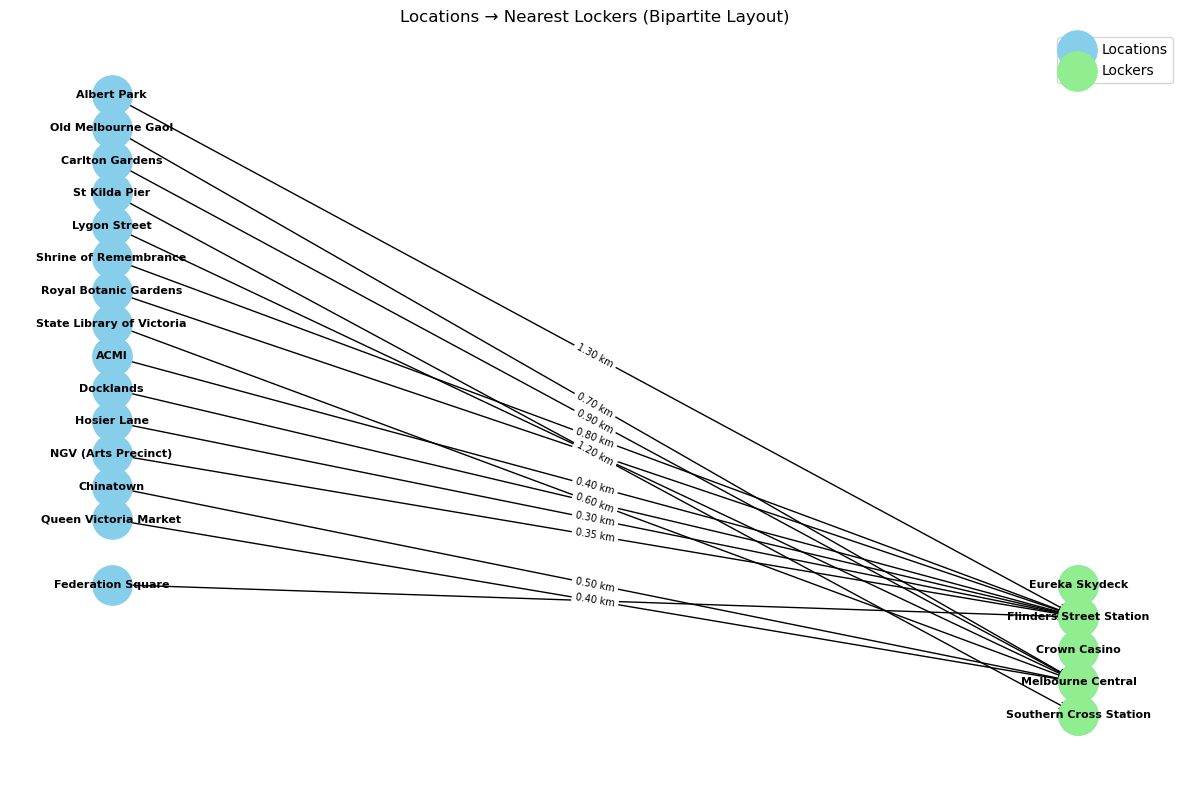

In [9]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Create directed graph
G = nx.DiGraph()

# Add nodes with a bipartite attribute (0 = location, 1 = locker)
locations = df["Location"].unique().tolist()
lockers = df["Nearest_Locker_Location"].dropna().unique().tolist()

for loc in locations:
    G.add_node(loc, bipartite=0)

for locker in lockers:
    if locker not in G:  # avoid duplicates
        G.add_node(locker, bipartite=1)

# Add edges with distance as label
for _, row in df.iterrows():
    src = row["Location"]
    dst = row["Nearest_Locker_Location"]
    if pd.notna(dst) and src != dst:
        G.add_edge(src, dst, distance=row["Travel_Distance_km"])

# Create bipartite layout: locations left, lockers right
pos = {}
pos.update((node, (0, i)) for i, node in enumerate(locations))  # left column
pos.update((node, (1, i)) for i, node in enumerate(lockers))    # right column

plt.figure(figsize=(12, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=locations, node_color="skyblue", node_size=800, label="Locations")
nx.draw_networkx_nodes(G, pos, nodelist=lockers, node_color="lightgreen", node_size=800, label="Lockers")

# Draw edges
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=12)

# Labels
nx.draw_networkx_labels(G, pos, font_size=8, font_weight="bold")

# Edge labels (distance in km)
edge_labels = {(u, v): f"{d['distance']:.2f} km" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

plt.title("Locations → Nearest Lockers (Bipartite Layout)")
plt.legend(scatterpoints=1)
plt.axis("off")
plt.tight_layout()
plt.show()

